# Notebook for image segmentation
- Cut big image in small pieces for segmentation
- Reconstruct image
- Extract instensity in cell masks

In [1]:
import numpy as np
import tifffile
import glob
import pandas
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import griottes
from scripts import image_preparation

### Load image

In [2]:
IMAGE_PATH = r'Example_image'
img = tifffile.imread(os.path.join(IMAGE_PATH, '221212_6.tif'))
img = np.swapaxes(img, 0,2)

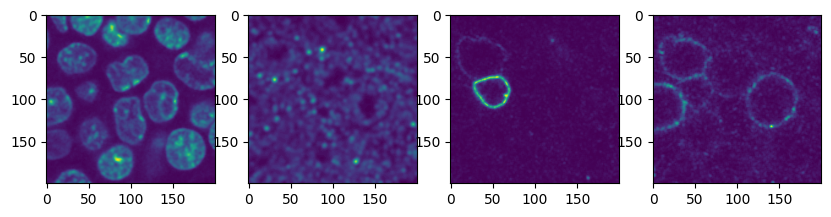

In [3]:
nx,ny,nc = img.shape

fig, ax = plt.subplots(1,nc, figsize = (10,3))

for i in range(nc):
    ax[i].imshow(img[5000:5200,5000:5200,i])

### Cut image in pieces 3000x3000 pixels

In [4]:
multi_matrix, codex = image_preparation.image_cutter(
    img[...,0],
    max_image_size = 3000,
    cut_in_z_direction = False,
    image_is_2D = True)

In [5]:
SAVE_PATH = os.path.join('Example_image')

- The function below cut the image in pieces 3000x3000 and place them in folders called saucisson_00, saucisson_01 ...
- The number of image per folder can be choose (here it is set to 100) : image_piece_0000.tif, image_piece_0001.tif, image_piece_0002.tif, image_piece_0003.tif ...
- If you loose a GPU with low memory for segmentation, place a low number of images inside each folder

In [ ]:
image_preparation.save_cut_images(multi_matrix,
                    SAVE_PATH,
                    dirname = 'saucisson_',
                    savename = 'image_piece_',
                    number_images_per_batch = 100)

### Here --> segment image fragments using Cellpose
- Cellpose will automatically create segmented files : image_piece_0000_seg.npy, image_piece_0001_seg.npy, image_piece_0002_seg.npy, image_piece_0003_seg.npy in the folder

### Reconstruct segmented image

In [ ]:
image_name = '221212_6'

image_preparation.reconstruct_image(SAVE_PATH,
                  original_image = img,
                  codex = codex,
                  image_name = image_name,
                  max_image_size = 3000, 
                  image_is_2D=True)

In [7]:
img_name = '221212_6_labeled.tif'

img_seg = tifffile.imread(os.path.join(IMAGE_PATH, img_name))

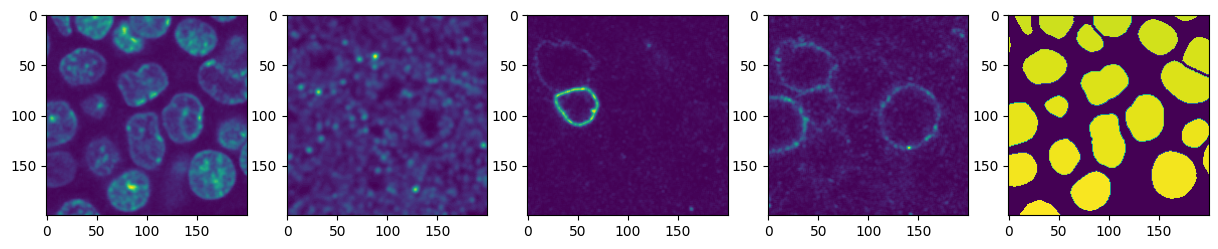

In [9]:
nx,ny,nc = img_seg.shape

fig, ax = plt.subplots(1,nc, figsize = (15,5))

for i in range(nc):
    ax[i].imshow(img_seg[5000:5200,5000:5200,i])

### Extract properties from image using Griottes

In [ ]:
prop = griottes.analyse.cell_property_extraction.get_cell_properties(
    img_seg,
    mask_channel = 4,
    analyze_fluo_channels = True,
    fluo_channel_analysis_method = 'basic',
    cell_geometry_properties = False,
    labeled_voronoi_tesselation = False,
    radius = 100,
    percentile = 95,
    min_area = 50,
    ndim = 2)

prop = prop.dropna()
prop['log_mean_intensity_0'] = np.log(prop.mean_intensity_0)
prop['log_mean_intensity_1'] = np.log(prop.mean_intensity_1)
prop['log_mean_intensity_2'] = np.log(prop.mean_intensity_2)
prop['log_mean_intensity_3'] = np.log(prop.mean_intensity_3)

prop = prop.rename(columns={"x": "y"})
prop = prop.rename(columns={"z": "x"})

In [ ]:
# Save resulting table
prop.to_csv(os.path.join(IMAGE_PATH, '221212_6_labeled.csv'))

### Cut small square 80x80 pixels around each cells
- Do this in all channels having membrane staining to classify these cells using neural network

In [3]:
prop = pandas.read_csv(os.path.join(IMAGE_PATH, '221212_6_labeled.csv'))

In [ ]:
selection_channel = 2
nuclei_channel = 0

image_preparation.cell_selection(
    img_seg,
    prop,
    nuclei_channel,
    selection_channel,
    dx = 80,
    savedir= IMAGE_PATH,
)

selection_channel = 3
nuclei_channel = 0

image_preparation.cell_selection(
    img_seg,
    prop,
    nuclei_channel,
    selection_channel,
    dx = 80,
    savedir= IMAGE_PATH,
)

### Note
An example of this procedure is given on a subset of 400 cells in this tutorial for easier visualization and navigation through the folders